# Wumpus World Unity Environment Log Analysis

This notebook contains our analysis of performance logs from different AI agent implementations in the Wumpus World Unity environment.

We compare execution times and behavioral patterns across multiple scenarios with varying complexity.

## Context

The analysis focuses on different AI types including:
- Basic Rule-based agents
- Finite State Machine agents
- Behavior Tree agents
- Prolog agents
- Prolog Meta Interpreter agents

Each scenario uses different configurations of world size, number of agents, and dangers (pits and Wumpus) distribution.

Common parameters across all configurations:
| Parameter | Value |
|:----------|:------|
| **randomSeed** | 1 |
| **nbGold** | 1 |
| **nbAgent** | [1, 5, 10] |
| **aiType** | [Basic, FiniteStateMachine, BehaviorTree, Prolog, PrologMetaInterpreter] |
| **personalities** | [(cupid & brave), (ascetic & coward), (cupid & coward)] |

### Grid-Specific Configurations

| Grid Size | Number of Pits & Wumpus |
|:---------:|:-------------:|
| 10x10     | 3          |
| 15x15     | 7          |
| 20x20     | 12         |
| 25x25     | 19         |
| 30x30     | 27         |
| 50x50     | 75         |
| 100x100   | 300        |

We have 7 grid sizes, 3 personality sets, 5 AI types, and 3 agent numbers.

So, there are `7*3*5*3=315` configurations.

### Data Collection

Files are stored in the `data` directory (same as this file). The data is organized in subdirectories based on the grid size:
- 10x10
- 15x15
- 20x20
- 25x25
- 30x30
- 50x50
- 100x100

Each json file follows the naming convention:
```
<grid_size>_<nb_agents>_<nb_wumpus_pits>_<nb_gold>_<personality1>_<personality2>_<ai_type>.json
```

For example, for a 10x10 grid with 1 agent, 3 wumpus, 3 pits, and 1 gold, using the Cupid and Coward personalities with a Basic AI type, the file would be in folder `10x10` under the name:
```
10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json
```

### Data Structure

Each JSON file contains an array with two objects:

1. **Game Configuration and Performance Data**:
    - `randomSeed`: The seed used for randomization
    - `gridMin` & `gridMax`: Boundaries of the grid
    - `tileSize`: Size of each tile
    - `nbPit`, `nbWumpus`, `nbGold`: Number of pits, wumpuses, and gold
    - `nbAgent`: Number of agents
    - `aiType`: Type of AI used (Basic, Prolog, BehaviourTree, etc.)
    - `personalities`: Array of personality type IDs
    - `isGameOver`: Whether the game has ended
    - `isModeAuto`: Whether the game is running in automatic mode
    - `turnDuration`: Array of turn durations in milliseconds

2. **Agent Behavior Data**:
    - `agent`: Agent identifier
    - `actions`: Array of actions taken by the agent
    - `positions`: Array of position objects, with x,y coordinates for each turn

See [10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json](10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json) for an example of the data structure.

## 1. Initial Data Analysis

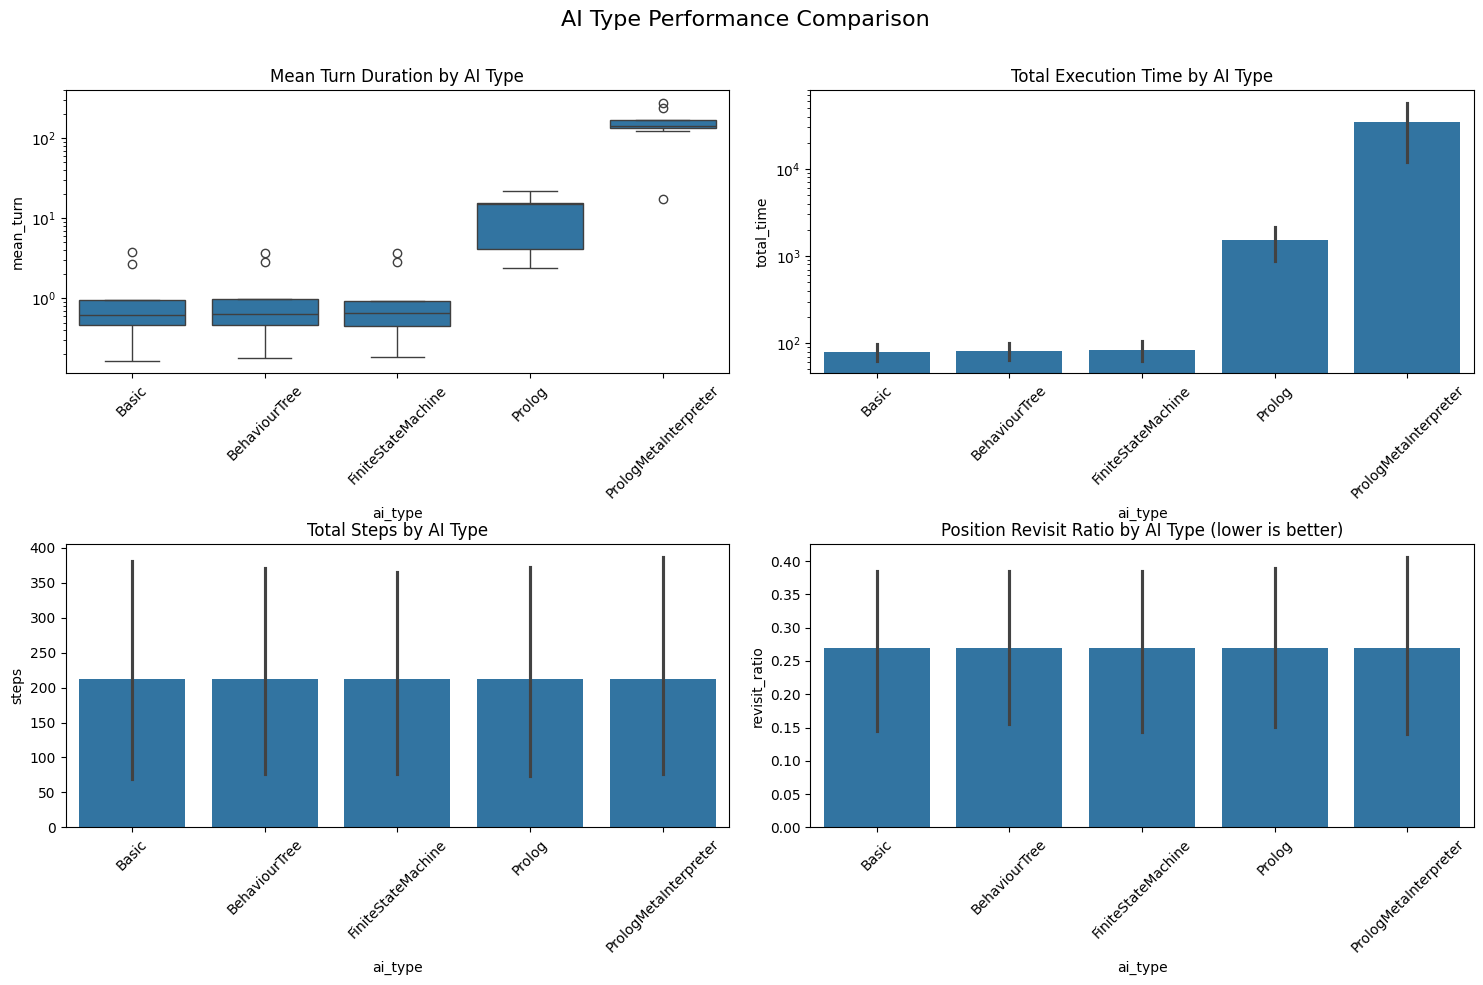

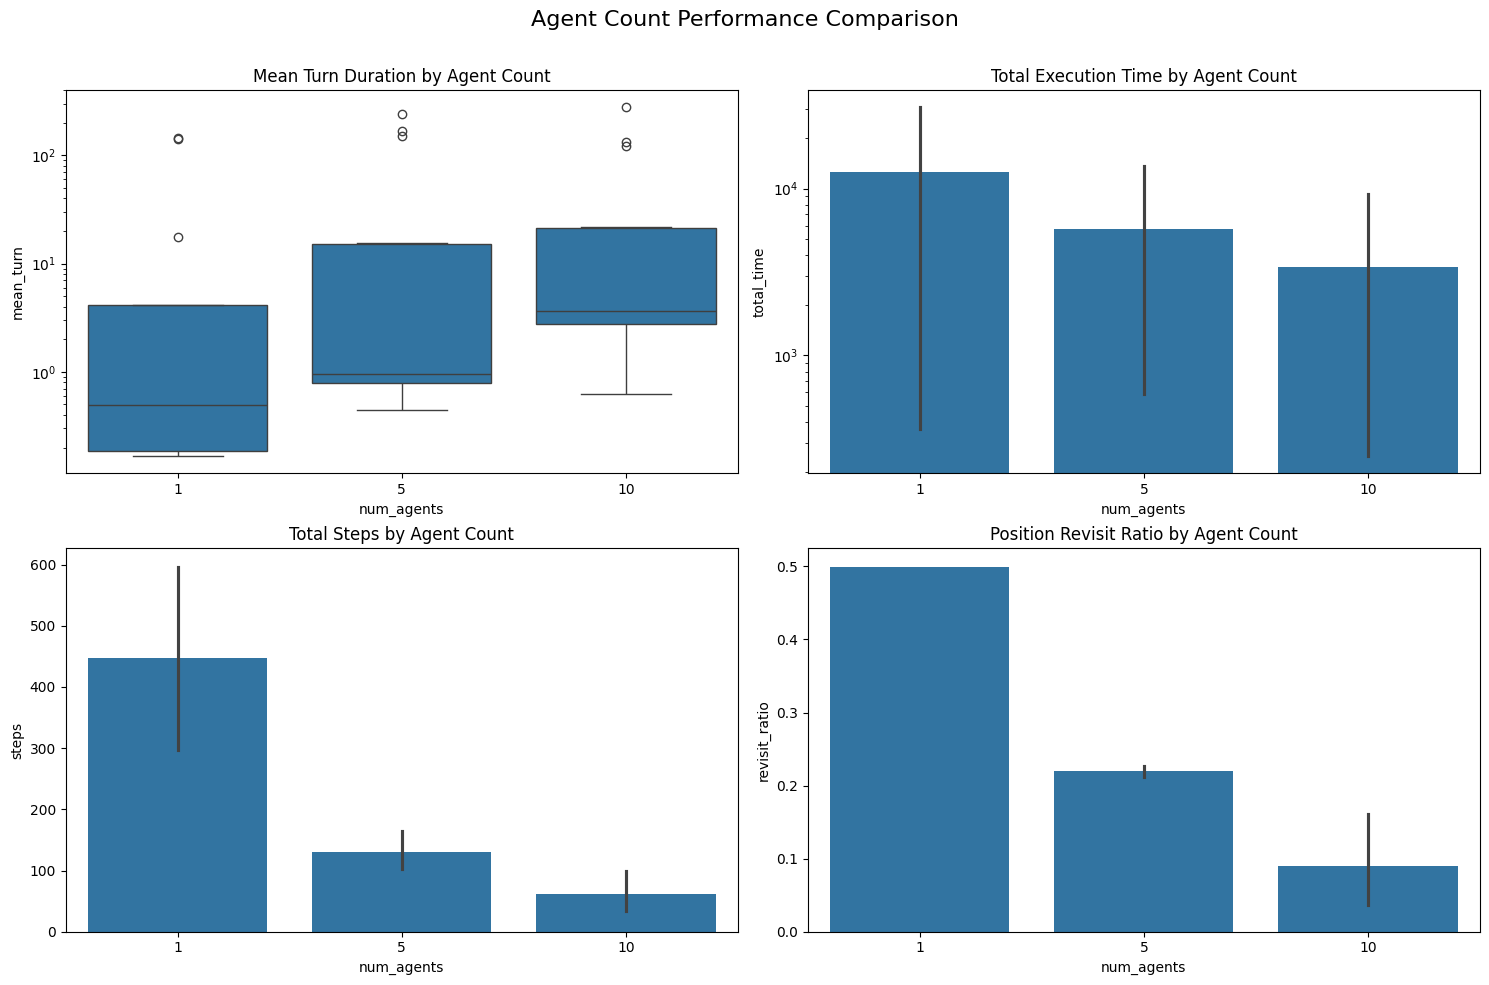

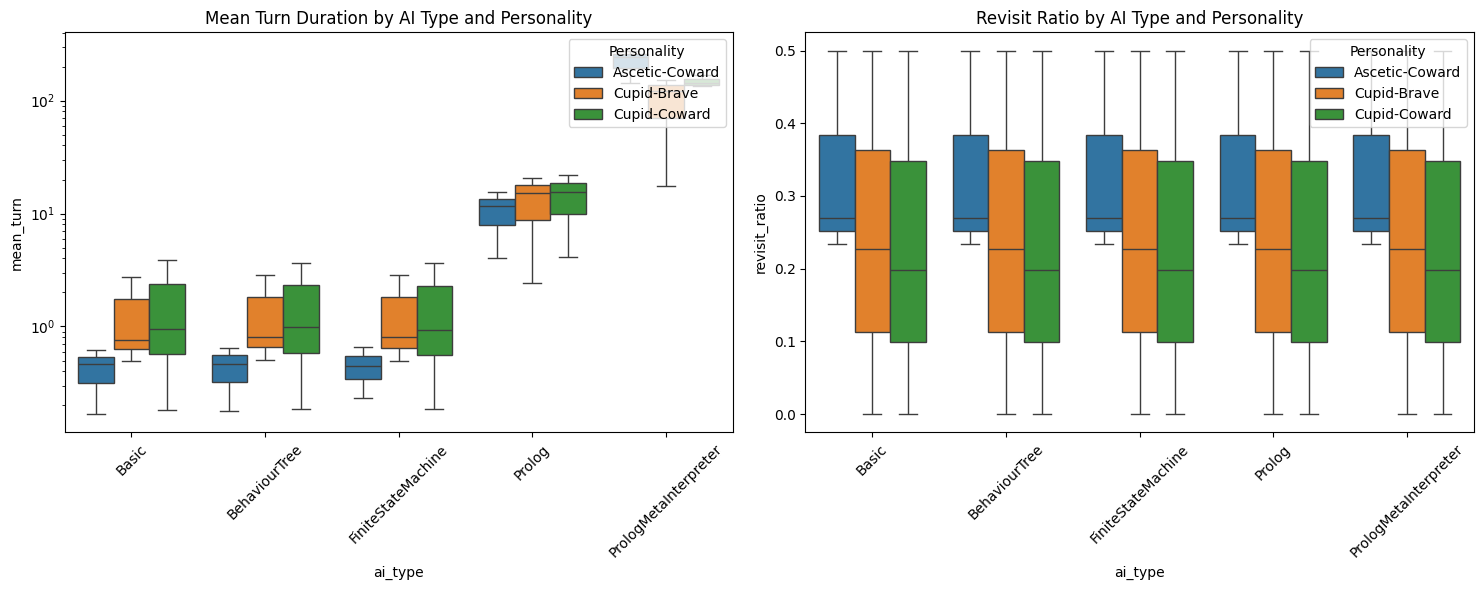

Summary of Performance Metrics by AI Type:
              ai_type  mean_turn  median_turn  total_time  steps  revisit_ratio
                Basic       1.13         0.36       78.79 212.78           0.27
        BehaviourTree       1.14         0.39       81.47 212.78           0.27
   FiniteStateMachine       1.14         0.36       83.97 212.78           0.27
               Prolog      12.32        12.27     1522.27 212.78           0.27
PrologMetaInterpreter     155.43       162.15    34560.77 212.78           0.27

Summary by Number of Agents:
 num_agents  mean_turn  total_time  steps  revisit_ratio
          1      21.16    12636.73 447.00           0.50
          5      40.72     5758.17 129.67           0.22
         10      40.82     3401.46  61.67           0.09

Summary by Personality:
   personality  mean_turn  total_time  steps  revisit_ratio
Ascetic-Coward      46.44    13032.33 335.33           0.33
   Cupid-Brave      22.80     1262.43  58.33           0.24
  Cupid-Coward

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns
from glob import glob


# Keep the existing functions
def load_json_data(file_path):
    """Load data from a JSON file."""
    with open(file_path, "r") as f:
        return json.load(f)


def get_turn_duration_stats(data):
    """Extract turn duration statistics from game data."""
    turn_durations = data[0]["turnDuration"]
    return {
        "mean": np.mean(turn_durations),
        "median": np.median(turn_durations),
        "min": np.min(turn_durations),
        "max": np.max(turn_durations),
        "std": np.std(turn_durations),
        "total": np.sum(turn_durations),
        "count": len(turn_durations),
    }


def analyze_agent_actions(data):
    """Analyze the frequency of different actions taken by agent."""
    actions = data[1]["actions"]
    action_counts = {}
    for action in actions:
        if action in action_counts:
            action_counts[action] += 1
        else:
            action_counts[action] = 1
    return action_counts


# Define function to calculate movement efficiency
def calculate_movement_efficiency(positions):
    total_steps = len(positions) - 1
    unique_positions = len(set((pos["x"], pos["y"]) for pos in positions))
    revisit_ratio = 1 - (unique_positions / len(positions))
    return {
        "total_steps": total_steps,
        "unique_positions": unique_positions,
        "revisit_ratio": revisit_ratio,
    }


# Function to parse file name to extract metadata
def parse_filename(filename):
    # Using regex to extract parts from filename
    pattern = r"(\d+)x\d+-(\d+)a-\d+wp-\d+g-(\w+)-(\w+)-(\w+).json"
    match = re.search(pattern, filename)
    if match:
        grid_size = match.group(1)
        num_agents = match.group(2)
        trait1 = match.group(3)
        trait2 = match.group(4)
        ai_type = match.group(5)
        return {
            "grid_size": int(grid_size),
            "num_agents": int(num_agents),
            "trait1": trait1,
            "trait2": trait2,
            "ai_type": ai_type,
            "personality": f"{trait1}-{trait2}",
        }
    return None


# Load data from all files
all_data = {}
metadata = []

# Use glob to find all .json files in the ?x? directory
file_paths = glob("20x20/*.json")

# Sort the file paths for consistent processing
file_paths.sort()

# Process files and extract metadata
for file_path in file_paths:
    meta = parse_filename(file_path)
    if meta:
        data = load_json_data(file_path)

        # Collect stats
        turn_stats = get_turn_duration_stats(data)
        action_counts = analyze_agent_actions(data)
        movement_efficiency = calculate_movement_efficiency(data[1]["positions"])

        # Store all info
        file_key = (
            f"{meta['num_agents']}a-{meta['trait1']}-{meta['trait2']}-{meta['ai_type']}"
        )
        all_data[file_key] = {
            "data": data,
            "meta": meta,
            "stats": {
                "turn_stats": turn_stats,
                "action_counts": action_counts,
                "movement_efficiency": movement_efficiency,
            },
        }

        # Add stats to metadata for DataFrame
        meta_entry = {
            **meta,
            "mean_turn": turn_stats["mean"],
            "median_turn": turn_stats["median"],
            "max_turn": turn_stats["max"],
            "total_time": turn_stats["total"],
            "steps": movement_efficiency["total_steps"],
            "revisit_ratio": movement_efficiency["revisit_ratio"],
            "actions": len(action_counts),
        }
        metadata.append(meta_entry)

# Create DataFrame for easier analysis
df = pd.DataFrame(metadata)

# Analysis by AI type
plt.figure(figsize=(15, 10))

# Turn duration by AI type
plt.subplot(2, 2, 1)
sns.boxplot(x="ai_type", y="mean_turn", data=df)
plt.title("Mean Turn Duration by AI Type")
plt.yscale("log")  # Log scale to handle large differences
plt.xticks(rotation=45)

# Total time by AI type
plt.subplot(2, 2, 2)
sns.barplot(x="ai_type", y="total_time", data=df)
plt.title("Total Execution Time by AI Type")
plt.yscale("log")
plt.xticks(rotation=45)

# Steps by AI type
plt.subplot(2, 2, 3)
sns.barplot(x="ai_type", y="steps", data=df)
plt.title("Total Steps by AI Type")
plt.xticks(rotation=45)

# Revisit ratio by AI type
plt.subplot(2, 2, 4)
sns.barplot(x="ai_type", y="revisit_ratio", data=df)
plt.title("Position Revisit Ratio by AI Type (lower is better)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("AI Type Performance Comparison", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Analysis by number of agents
plt.figure(figsize=(15, 10))

# Turn duration by agent count
plt.subplot(2, 2, 1)
sns.boxplot(x="num_agents", y="mean_turn", data=df)
plt.title("Mean Turn Duration by Agent Count")
plt.yscale("log")

# Total time by agent count
plt.subplot(2, 2, 2)
sns.barplot(x="num_agents", y="total_time", data=df)
plt.title("Total Execution Time by Agent Count")
plt.yscale("log")

# Steps by agent count
plt.subplot(2, 2, 3)
sns.barplot(x="num_agents", y="steps", data=df)
plt.title("Total Steps by Agent Count")

# Revisit ratio by agent count
plt.subplot(2, 2, 4)
sns.barplot(x="num_agents", y="revisit_ratio", data=df)
plt.title("Position Revisit Ratio by Agent Count")

plt.tight_layout()
plt.suptitle("Agent Count Performance Comparison", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Interaction between AI type and personality
plt.figure(figsize=(15, 6))

# Mean turn duration
plt.subplot(1, 2, 1)
sns.boxplot(x="ai_type", y="mean_turn", hue="personality", data=df)
plt.title("Mean Turn Duration by AI Type and Personality")
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Personality", loc="upper right")

# Revisit ratio
plt.subplot(1, 2, 2)
sns.boxplot(x="ai_type", y="revisit_ratio", hue="personality", data=df)
plt.title("Revisit Ratio by AI Type and Personality")
plt.xticks(rotation=45)
plt.legend(title="Personality", loc="upper right")

plt.tight_layout()
plt.show()

# Create summary table
print("Summary of Performance Metrics by AI Type:")
ai_summary = (
    df.groupby("ai_type")
    .agg(
        {
            "mean_turn": "mean",
            "median_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
            "revisit_ratio": "mean",
        }
    )
    .reset_index()
)

print(ai_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Number of Agents:")
agent_summary = (
    df.groupby("num_agents")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
            "revisit_ratio": "mean",
        }
    )
    .reset_index()
)

print(agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Personality:")
personality_summary = (
    df.groupby("personality")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
            "revisit_ratio": "mean",
        }
    )
    .reset_index()
)

print(personality_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))


## 2. Extra Data Analysis


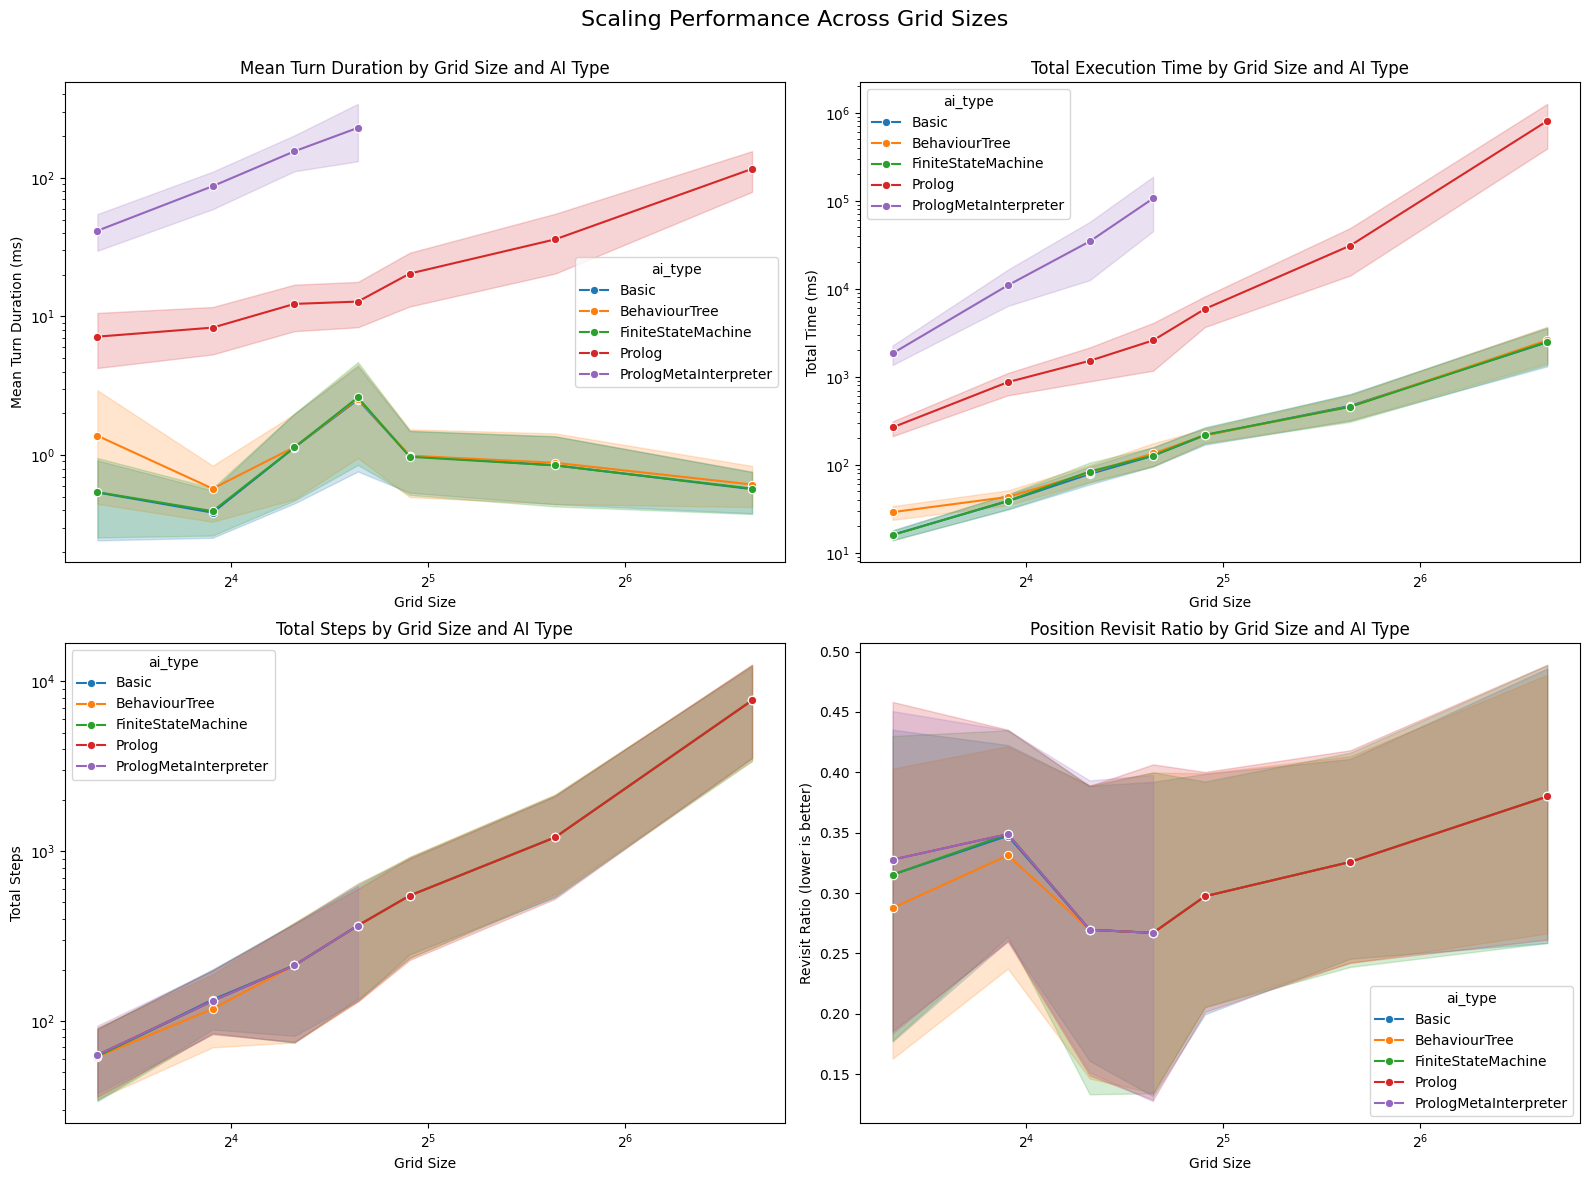

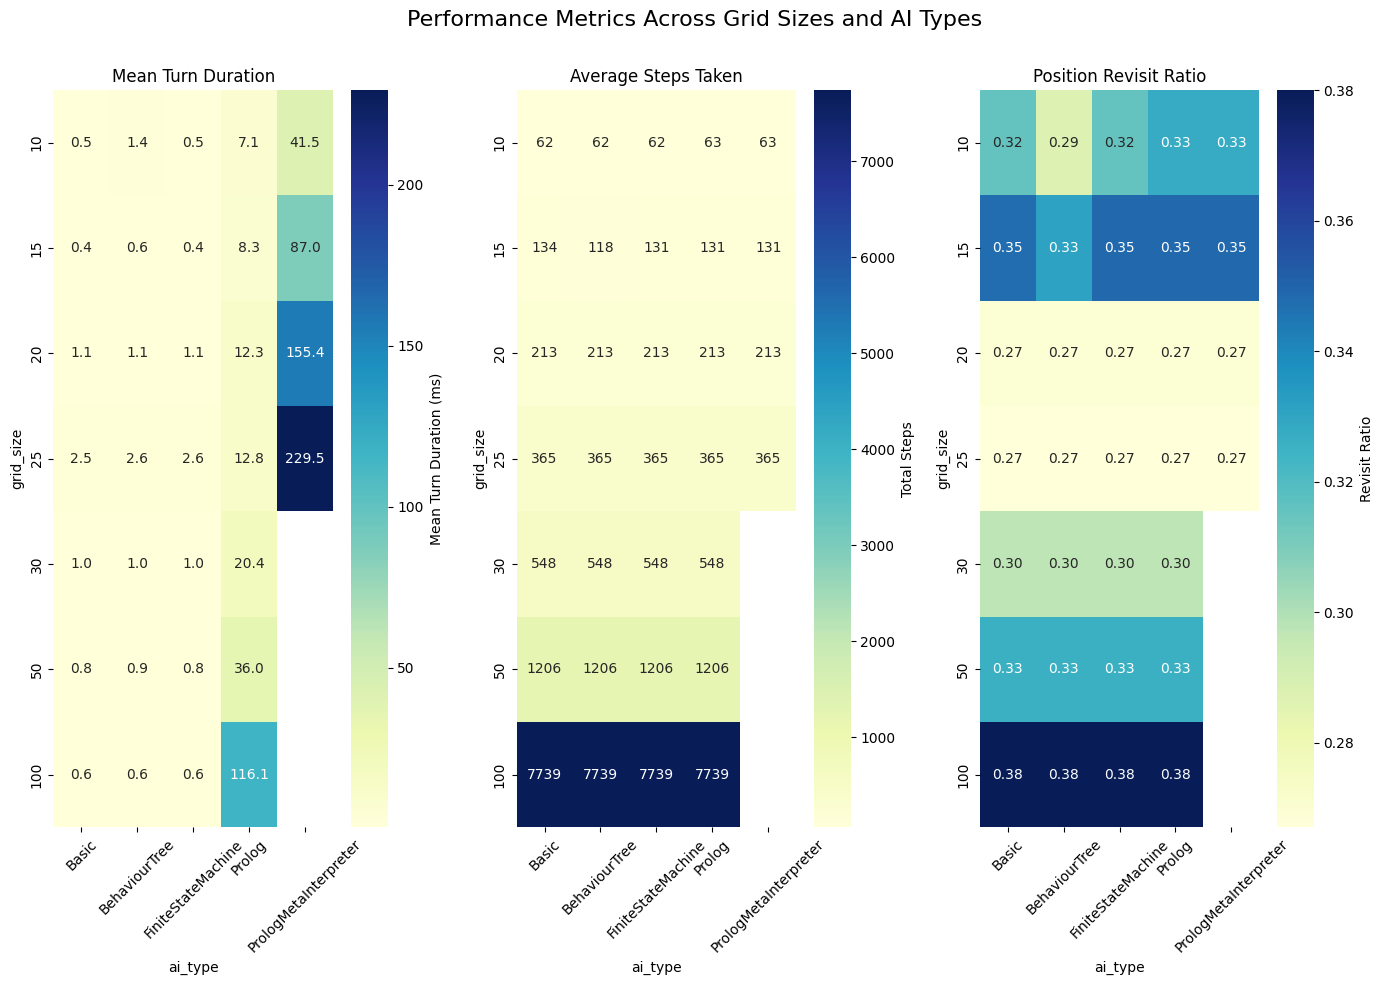

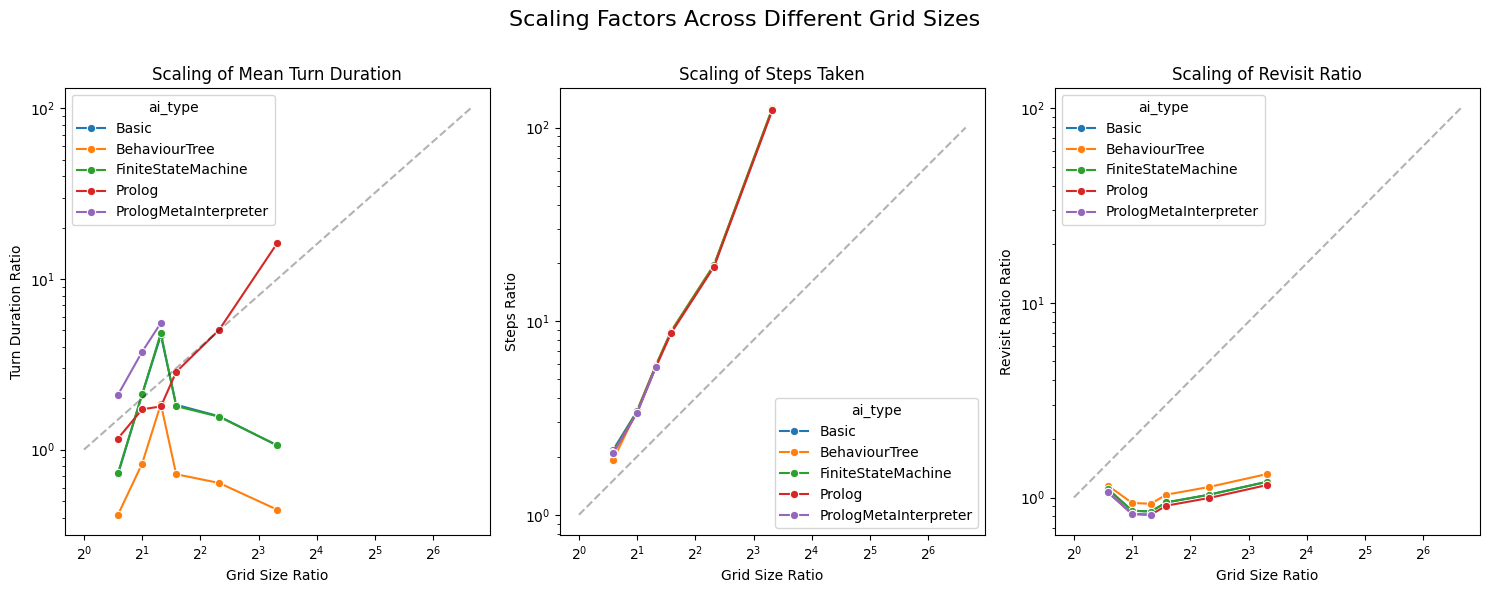

Scaling Efficiency Summary (average scaling factor by AI type):
metric                 mean_turn  revisit_ratio  steps
ai_type                                               
Basic                       0.74           0.36   4.14
BehaviourTree               0.31           0.39   4.14
FiniteStateMachine          0.75           0.36   4.13
Prolog                      0.99           0.34   4.06
PrologMetaInterpreter       1.83           0.48   1.80


In [2]:
# Extend analysis to all grid sizes
all_metadata = []

# Process files from all grid sizes
for grid_size in [10, 15, 20, 25, 30, 50, 100]:
    file_paths = glob(f"{grid_size}x{grid_size}/*.json")
    file_paths.sort()

    for file_path in file_paths:
        meta = parse_filename(file_path)
        if meta:
            data = load_json_data(file_path)
            turn_stats = get_turn_duration_stats(data)
            action_counts = analyze_agent_actions(data)
            movement_efficiency = calculate_movement_efficiency(data[1]["positions"])

            meta_entry = {
                **meta,
                "mean_turn": turn_stats["mean"],
                "median_turn": turn_stats["median"],
                "max_turn": turn_stats["max"],
                "total_time": turn_stats["total"],
                "steps": movement_efficiency["total_steps"],
                "revisit_ratio": movement_efficiency["revisit_ratio"],
                "actions": len(action_counts),
            }
            all_metadata.append(meta_entry)

# Create DataFrame for comprehensive analysis
all_df = pd.DataFrame(all_metadata)

# Visualize scaling with grid size
plt.figure(figsize=(16, 12))

# Mean turn duration by grid size and AI type
plt.subplot(2, 2, 1)
sns.lineplot(x="grid_size", y="mean_turn", hue="ai_type", data=all_df, marker="o")
plt.title("Mean Turn Duration by Grid Size and AI Type")
plt.xscale("log", base=2)  # Use log scale with base 2 instead of log2
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Mean Turn Duration (ms)")

# Total time by grid size and AI type
plt.subplot(2, 2, 2)
sns.lineplot(x="grid_size", y="total_time", hue="ai_type", data=all_df, marker="o")
plt.title("Total Execution Time by Grid Size and AI Type")
plt.xscale("log", base=2)  # Use log scale with base 2 instead of log2
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Total Time (ms)")

# Steps by grid size and AI type
plt.subplot(2, 2, 3)
sns.lineplot(x="grid_size", y="steps", hue="ai_type", data=all_df, marker="o")
plt.title("Total Steps by Grid Size and AI Type")
plt.xscale("log", base=2)  # Use log scale with base 2 instead of log2
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Total Steps")

# Revisit ratio by grid size and AI type
plt.subplot(2, 2, 4)
sns.lineplot(x="grid_size", y="revisit_ratio", hue="ai_type", data=all_df, marker="o")
plt.title("Position Revisit Ratio by Grid Size and AI Type")
plt.xscale("log", base=2)  # Use log scale with base 2 instead of log2
plt.xlabel("Grid Size")
plt.ylabel("Revisit Ratio (lower is better)")

plt.tight_layout()
plt.suptitle("Scaling Performance Across Grid Sizes", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

# Heatmap of performance metrics by grid size and AI type
plt.figure(figsize=(14, 10))

# Pivot data for heatmaps
pivot_time = all_df.pivot_table(
    index="grid_size", columns="ai_type", values="mean_turn", aggfunc="mean"
)
pivot_steps = all_df.pivot_table(
    index="grid_size", columns="ai_type", values="steps", aggfunc="mean"
)
pivot_revisit = all_df.pivot_table(
    index="grid_size", columns="ai_type", values="revisit_ratio", aggfunc="mean"
)

# Time heatmap
plt.subplot(1, 3, 1)
sns.heatmap(
    pivot_time,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={"label": "Mean Turn Duration (ms)"},
)
plt.title("Mean Turn Duration")
plt.xticks(rotation=45)

# Steps heatmap
plt.subplot(1, 3, 2)
sns.heatmap(
    pivot_steps, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "Total Steps"}
)
plt.title("Average Steps Taken")
plt.xticks(rotation=45)

# Revisit ratio heatmap
plt.subplot(1, 3, 3)
sns.heatmap(
    pivot_revisit,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={"label": "Revisit Ratio"},
)
plt.title("Position Revisit Ratio")
plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("Performance Metrics Across Grid Sizes and AI Types", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Analyze scaling efficiency
# Calculate how performance metrics scale with grid size
scaling_analysis = (
    all_df.groupby(["ai_type", "grid_size"])
    .agg({"mean_turn": "mean", "steps": "mean", "revisit_ratio": "mean"})
    .reset_index()
)

# Calculate growth rates
scaling_results = []
ai_types = scaling_analysis["ai_type"].unique()

for ai in ai_types:
    ai_data = scaling_analysis[scaling_analysis["ai_type"] == ai].sort_values(
        "grid_size"
    )

    for metric in ["mean_turn", "steps", "revisit_ratio"]:
        base_grid = ai_data.iloc[0]["grid_size"]
        base_value = ai_data.iloc[0][metric]

        for i in range(1, len(ai_data)):
            current_grid = ai_data.iloc[i]["grid_size"]
            current_value = ai_data.iloc[i][metric]

            grid_ratio = current_grid / base_grid
            value_ratio = current_value / base_value
            scaling_factor = value_ratio / grid_ratio

            scaling_results.append(
                {
                    "ai_type": ai,
                    "metric": metric,
                    "base_grid": base_grid,
                    "current_grid": current_grid,
                    "grid_ratio": grid_ratio,
                    "value_ratio": value_ratio,
                    "scaling_factor": scaling_factor,
                }
            )

scaling_df = pd.DataFrame(scaling_results)

# Visualize scaling factors
plt.figure(figsize=(15, 6))

# Scaling of mean turn duration
plt.subplot(1, 3, 1)
sns.lineplot(
    x="grid_ratio",
    y="value_ratio",
    hue="ai_type",
    data=scaling_df[scaling_df["metric"] == "mean_turn"],
    marker="o",
)
plt.title("Scaling of Mean Turn Duration")
plt.xscale("log", base=2)  # Consistent with grid ratio scale
plt.yscale("log")
plt.xlabel("Grid Size Ratio")
plt.ylabel("Turn Duration Ratio")
plt.plot([1, 100], [1, 100], "k--", alpha=0.3)  # Linear scaling reference

# Scaling of steps
plt.subplot(1, 3, 2)
sns.lineplot(
    x="grid_ratio",
    y="value_ratio",
    hue="ai_type",
    data=scaling_df[scaling_df["metric"] == "steps"],
    marker="o",
)
plt.title("Scaling of Steps Taken")
plt.xscale("log", base=2)  # Consistent with grid ratio scale
plt.yscale("log")
plt.xlabel("Grid Size Ratio")
plt.ylabel("Steps Ratio")
plt.plot([1, 100], [1, 100], "k--", alpha=0.3)  # Linear scaling reference

# Scaling of revisit ratio
plt.subplot(1, 3, 3)
sns.lineplot(
    x="grid_ratio",
    y="value_ratio",
    hue="ai_type",
    data=scaling_df[scaling_df["metric"] == "revisit_ratio"],
    marker="o",
)
plt.title("Scaling of Revisit Ratio")
plt.xscale("log", base=2)  # Consistent with grid ratio scale
plt.yscale("log")
plt.xlabel("Grid Size Ratio")
plt.ylabel("Revisit Ratio Ratio")
plt.plot([1, 100], [1, 100], "k--", alpha=0.3)  # Linear scaling reference

plt.tight_layout()
plt.suptitle("Scaling Factors Across Different Grid Sizes", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

# Print summary of scaling efficiency
print("Scaling Efficiency Summary (average scaling factor by AI type):")
scaling_summary = (
    scaling_df.groupby(["ai_type", "metric"])["scaling_factor"].mean().reset_index()
)
scaling_summary_pivot = scaling_summary.pivot(
    index="ai_type", columns="metric", values="scaling_factor"
)
print(scaling_summary_pivot.to_string(float_format=lambda x: f"{x:.2f}"))

# A scaling factor of 1 indicates linear scaling
# Less than 1 is better than linear (sublinear)
# Greater than 1 is worse than linear (superlinear)
